In [26]:
# The aim of this notebook is to produce summary statistics for Hazards over a range of areas
# typical statistic include, median, min, max, 10th, 90th percentiles

In [27]:
# https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/python_tutorial.ipynb

In [28]:
import calendar

import xarray as xr
import geopandas as gp
import regionmask
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors as mplc
import numpy as np

In [29]:
from glob import glob 
import xarray as xr

In [30]:
filelist = glob("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/CSIRO/ACCESS-CM2/ssp126/r4i1p1f1/CCAM-v2203-SN/v1-r1/day/tasmax/*")


In [31]:
ds = xr.open_mfdataset(filelist,
                      # preprocess=_preprocess,
                      use_cftime = True)

In [32]:
ds

<xarray.Dataset> Size: 77GB
Dimensions:    (time: 31046, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * time       (time) object 248kB 2015-01-01 12:00:00 ... 2099-12-31 12:00:00
  * lat        (lat) float64 6kB -44.5 -44.45 -44.4 ... -10.1 -10.05 -10.0
  * lon        (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Dimensions without coordinates: bnds
Data variables:
    tasmax     (time, lat, lon) float32 76GB dask.array<chunksize=(1, 691, 886), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 343MB dask.array<chunksize=(365, 691, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 440MB dask.array<chunksize=(365, 886, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object 497kB dask.array<chunksize=(365, 2), meta=np.ndarray>
Attributes: (12/28)
    Conventions:             CF-1.10
    activity_id:             DD
    contact:                 ccam@csiro.au
    domain:                  Australia/AGCD
    domain_id:               AGCD-05i
    driving_experiment:      update of RCP2.6 based on SSP1
    ...                      ...
    variable_id:             tasmax
    input_tracking_id:       e85f5604-acda-4b0b-9155-912f71b77af2
    input_doi:               https://doi.org/10.25914/rd73-4m38
    title:                   Pre-processed model output in preparation for bi...
    history:                 Fri Apr 12 08:53:07 2024: ncatted -O -a least_si...
    NCO:                     netCDF Operators version 5.0.5 (Homepage = http:...

In [33]:
states_gp = gp.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/aus_states_territories/aus_states_territories.shp')
states_gp = states_gp[:-2] # exclude ACT and other territories 


In [34]:
states_regions = regionmask.from_geopandas(
    states_gp,
    names="STE_NAME21",
    abbrevs="ABBREV",
    name="states"
)

In [35]:
states_regions

<regionmask.Regions 'states'>
overlap:  None

Regions:
0 NSW    New South Wales
1 VIC           Victoria
2 QLD         Queensland
3  SA    South Australia
4  WA  Western Australia
5 TAS           Tasmania
6  NT Northern Territory

[7 regions]

In [36]:
# for default mask if only concerned in centre is within mask
mask_centre = states_regions.mask_3D(ds)





In [37]:
# # fractional mask is more memory intensive and more relevant for coarse resolution data
# frac = states_regions.mask_3D_frac_approx(ds)

# fg = frac.plot(
#     subplot_kws=dict(projection=ccrs.PlateCarree()),
#     col="region",
#     col_wrap=4,
#     transform=ccrs.PlateCarree(),
#     cmap='Blues',
# )
# for ax in fg.axs.flatten():
#     ax.coastlines()
#     ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
#     ax.add_feature(cartopy.feature.STATES)
# plt.show()

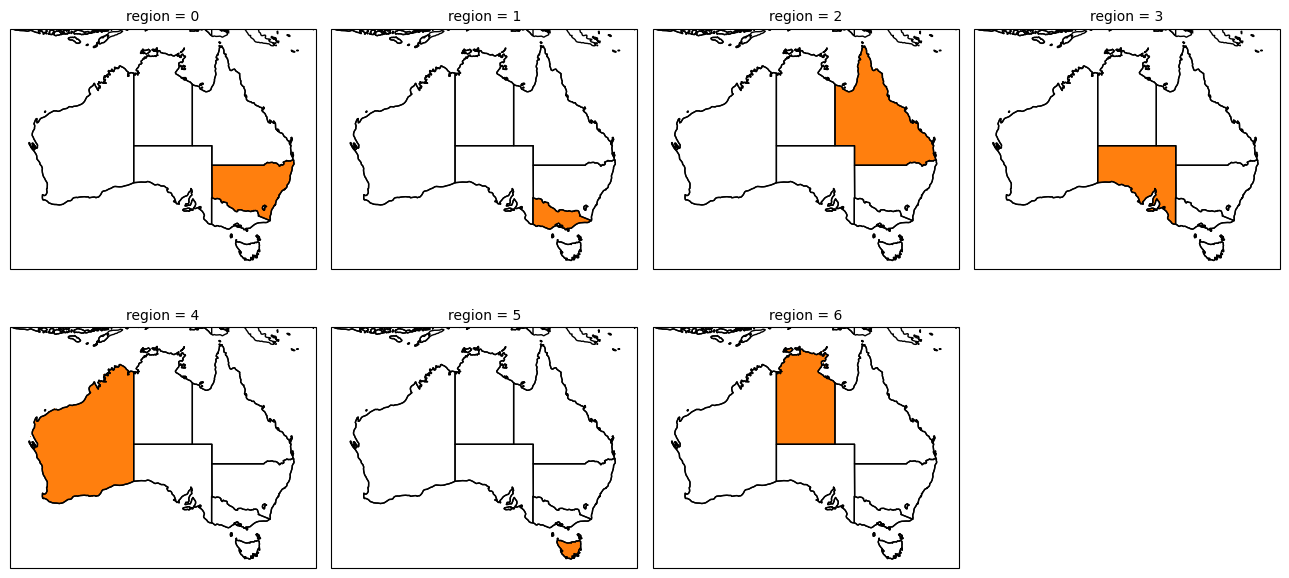

In [38]:
fg = mask_centre.plot(
    subplot_kws=dict(projection=ccrs.PlateCarree()),
    col="region",
    col_wrap=4,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    cmap=mplc.ListedColormap(["none", "tab:orange"]),
)
for ax in fg.axs.flatten():
    ax.coastlines()
    ax.set_extent([110, 157, -8, -45], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.STATES)
fg.fig.subplots_adjust(hspace=0.1, wspace=0.05)
plt.show()

In [39]:
qld_mask = mask_centre.isel(region = (mask_centre.names == "Queensland"))


In [40]:
ds_qld = ds.where(qld_mask)


In [44]:
crs = ccrs.LambertConformal(central_latitude = -24.75, central_longitude = 134.0,cutoff=30, standard_parallels=(-10,-40))


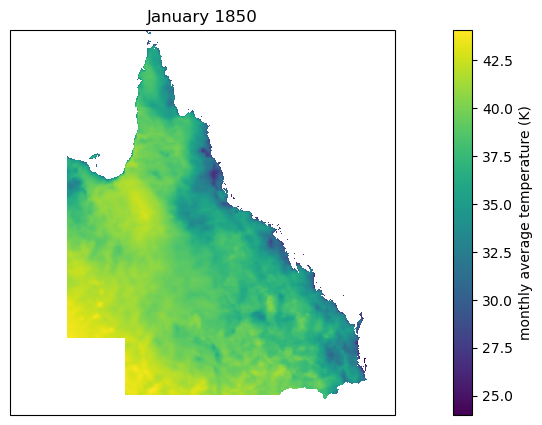

In [47]:
fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(111, projection=crs)
ds_qld['tasmax'].isel(time=0).plot(
    ax=ax,
    transform=crs,
    cbar_kwargs={'label': f'monthly average temperature (K)'},
)
ax.set_extent([135, 155, -10, -30], crs=crs )
ax.set_title('January 1850')
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
plt.show()

In [42]:
def _preprocess(ds):
    min_lon = -40
    min_lat = 120
    max_lon = -35
    max_lat = 125
    
    ds_area = ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    ds_ann = ds_area.mean(dim=["lat", "lon"]).tasmax.resample(time="1YE").mean(keep_attrs=True)
    return ds_ann

In [43]:
ds_area = ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
ds_ann = ds_area.mean(dim=["lat", "lon"]).tasmax.resample(time="1YE").mean(keep_attrs=True)

NameError: name 'min_lat' is not defined

In [ ]:
ds.sel(lat=slice(-44,-45))

In [ ]:
ds.load()

In [ ]:
area_average_tasmax = ds.mean(dim=["lat", "lon"]).tasmax

In [ ]:
area_average_tasmax.resample(time="1YE").mean().compute()

In [ ]:
# from one or many files, read netcdfs into

In [ ]:
# load some rainfall data
ds_pr = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/pr/pr_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc")
# annual total rainfall
da_pr_ann = ds_pr.sum(dim="time").pr
# rainfall for one month
da_pr_jan = ds_pr.sel(time = ds_pr.time.dt.month==1).sum(dim="time").pr
# rainfall anomaly for one month
da_pr_anom = da_pr_jan-da_pr_ann/12

In [ ]:
# input xr dataset